<a href="https://colab.research.google.com/github/pdrobny/MonReader/blob/main/PaulNet_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import userdata
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import tensorflow as tf
import random
import wandb
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, AvgPool2D, Conv2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# define a confusion matrix plotter for visualizing classification report results
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['flip', 'not flip']); ax.yaxis.set_ticklabels(['flip', 'not flip'])
    plt.show()

In [ ]:
# load files from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define configuration options
img_rows, img_cols = 150, 150
batch_size = 32
n_classes = 2
val_split = 0.2
verbosity = 1
path = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/training'
path_test = '/content/drive/MyDrive/Colab Notebooks/Apziva/MonReader/images/testing'
input_shape = (img_rows, img_cols, 3)
labels = ['flip', 'notflip']
seed = 42

In [ ]:

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = False,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = False,
    target_size=(img_rows, img_cols)
)


print("Train classes:", train_generator.class_indices)

# Compute class weights
y_train = train_generator.classes
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights_array))
print("Class weights:", class_weight)

Found 1238 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Train classes: {'flip': 0, 'notflip': 1}
Class weights: {0: np.float64(0.6655913978494624), 1: np.float64(2.00974025974026)}


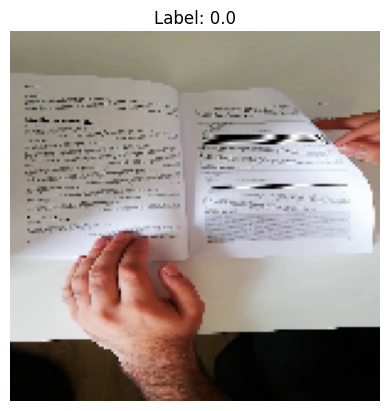

In [ ]:
#get images
images, labels = next(val_generator)

#select random image from batch
idx = random.randint(0, images.shape[0] - 1)

#show images
plt.imshow(images[idx])
plt.title(f"Label: {labels[idx]}")
plt.axis('off')
plt.show()

In [ ]:
class PaulNet:
      def __init__(self, optimizer, num_epochs, batch, pooling_type):
        self.optimizer = optimizer # examples: 'adam', 'sgb', 'lion
        self.num_epochs = num_epochs
        self.batch = batch # examples:  32, 64, 128
        self.pooling_type = pooling_type # 'max' for MaxPooling2D, 'avg' for AvgPool2D

      def pageflip(self):
        # Choose pooling layer based on self.pooling_type
        if self.pooling_type == 'max':
          pooling_layer = MaxPooling2D(pool_size=(2, 2))
        elif self.pooling_type == 'avg':
          pooling_layer = AvgPool2D(pool_size=(2, 2))
        else:
          raise ValueError("pooling_type must be 'max' or 'avg'")



        # Model architecture
        model = models.Sequential([
            layers.Input(shape=(img_rows, img_cols, 3)),

            layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            pooling_layer,
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(1, activation='sigmoid')  # Binary classification
        ])

        # print the summary of the model
        print(model.summary())

        # compile model
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])  #choose optimizer 'adam', 'sgd', or 'lion'

           # Callbacks to reduce overfitting
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
        ]

        # Train the model
        flip_model = model.fit(train_generator,
                                      steps_per_epoch=train_generator.samples // batch_size,
                                      epochs=self.num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=val_generator.samples // batch_size,
                                      class_weight=class_weight,
                                      callbacks=callbacks,
                                      verbose=1)
         # Predict on test set
        y_true = test_generator.classes
        y_pred_probs = model.predict(test_generator)


        # Final predictions
        #y_pred = (y_pred_probs > best_thresh).astype(int).flatten()
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        #print(f"\n🔍 Best Threshold: {best_thresh:.2f}")
        #print(f"✅ F1 Score: {best_f1:.4f}")
        class_names = list(test_generator.class_indices.keys())
        report_columns =  ["Class", "Precision", "Recall", "F1-score", "Support"]
        class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()).splitlines()


        report_table = []
        for line in class_report[2:(len(class_names)+2)]:
            report_table.append(line.split())
        #print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

        plot_confusion_matrix(y_true, y_pred)

        return model, flip_model, test_generator, y_true, y_pred, report_table

      def flip_test(self):
          # Predict on new data (example)
          sample_images, sample_labels = next(test_generator)
          predictions = model.predict(sample_images)
          predicted_classes = (predictions > 0.5).astype(int)
          y_true = sample_labels
          class_names = list(test_generator.class_indices.keys())
          # Show some predicted images
          for i in range(5):
              plt.imshow(sample_images[i])
              true_label = class_names[int(sample_labels[i])]
              predicted_label = 'flip' if predicted_classes[i][0] == 0 else 'notflip'
              plt.title(f"Actual: {true_label}, Predicted: {predicted_label}")
              plt.axis('off')
              plt.show()

          # Generate the classification report
          print(classification_report(y_true, predicted_classes, target_names=class_names))
          # plot confusion matrix
          plot_confusion_matrix(y_true, predicted_classes)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pdrobny (pdrobny-dominicap-trading) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,377 (40.58 MB)

 Trainable params: 10,636,929 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/2
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6954 - loss: 1.0514 - val_accuracy: 0.2639 - val_loss: 1.3696 - learning_rate: 0.0010
Epoch 2/2
 1/38 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.8125 - loss: 0.9518

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.8125 - loss: 0.9518 - val_accuracy: 0.2674 - val_loss: 1.3516 - learning_rate: 0.0010
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 853ms/step


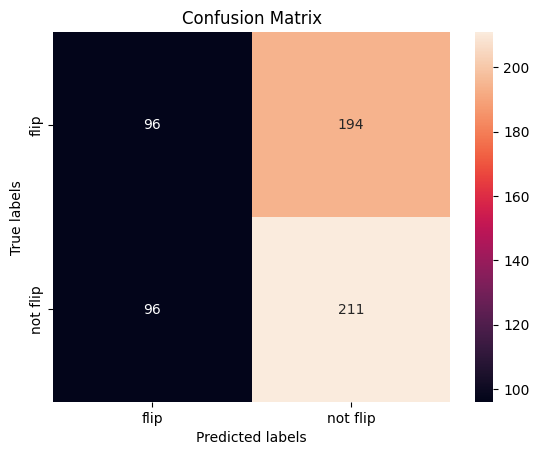

accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.8125
loss,0.95185
val_accuracy,0.26736
val_loss,1.35158


In [ ]:
#select attribute values
optimizer = 'adam' # examples: 'adam', 'sgd', 'lion
num_epochs = 2 # examples:5, 10, 15
batch = 32 # examples:  32, 64, 128
pooling_type = 'max' # 'max' for MaxPooling2D, 'avg' for AvgPool2D

# Start a new wandb run to track this script.
run = wandb.init(
    project='class report',
    notes='adam, max',
    config={
        'optimizer': optimizer,
        'num_epochs': num_epochs,
        'batch': batch,
        'pooling_type': pooling_type
    }
)


#pass selected attributes to new object
build = PaulNet(optimizer, num_epochs, batch, pooling_type)

# run the pageflip flip method on build object
model, flip_model, test_generator, y_true, y_pred, report_table = build.pageflip()

# define target names and report columns
target_names = list(test_generator.class_indices.keys())
report_columns =  ["Class", "Precision", "Recall", "F1-score", "Support"]

# log metrics
wandb.log({'accuracy': flip_model.history['accuracy'][-1]})
wandb.log({'loss': flip_model.history['loss'][-1]})
wandb.log({'val_accuracy': flip_model.history['val_accuracy'][-1]})
wandb.log({'val_loss': flip_model.history['val_loss'][-1]})
wandb.log({'classification_report': wandb.Table(data=report_table, columns=report_columns)})
wandb.log({'Confusion Matrix' : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true, preds=y_pred,
                        class_names=target_names)})


# Finish the run
wandb.finish()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


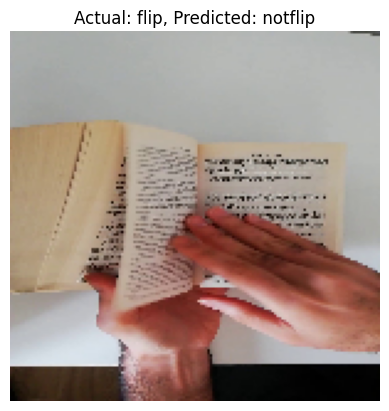

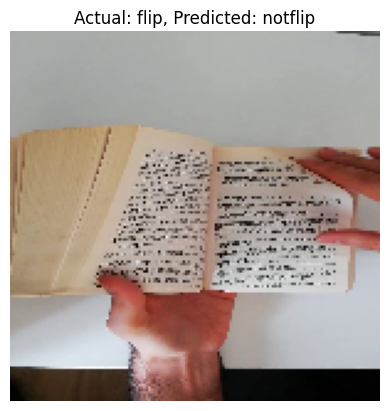

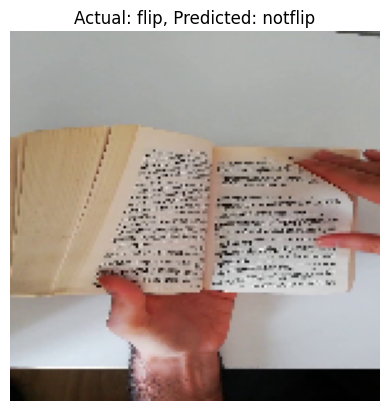

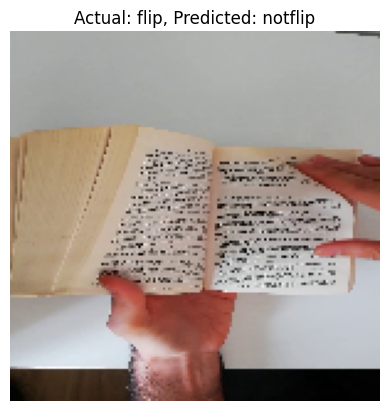

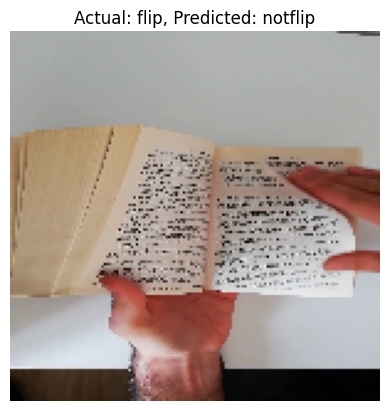

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        flip       1.00      0.06      0.12        32
     notflip       0.00      0.00      0.00         0

    accuracy                           0.06        32
   macro avg       0.50      0.03      0.06        32
weighted avg       1.00      0.06      0.12        32



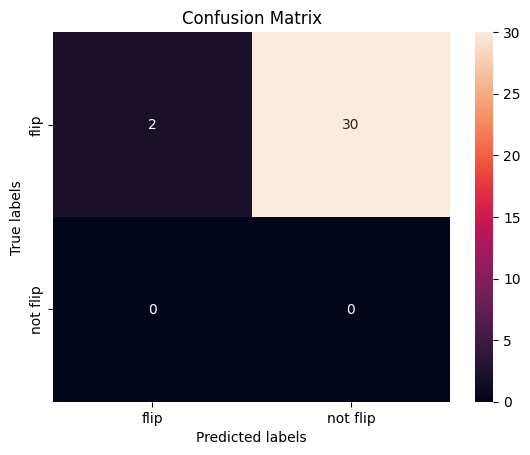

In [ ]:
build.flip_test()